# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

('Number of faces detected:', 1)


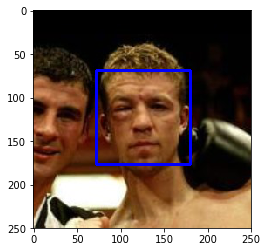

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

- 99 percent of the first 100 images in `human_files` have a detected human face
- 11 percent of the first 100 images in `dog_files` have a detected human face

In [5]:
from keras.preprocessing import image  
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_acc = 0
dog_acc = 0
for z in human_files_short:
    img = image.load_img(z, target_size=(224, 224))
    if face_detector(z):
        human_acc += 1
for image in dog_files_short:
    if face_detector(image):
        dog_acc += 1
print human_acc, dog_acc

    

99 11


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

This is reasonable if for say the purpose of face detection and face recognition is for biometric verification and entry to premises. Lights can be position such that it shines towards the human face and can increase clarity. Another way is to actually provide enough variations of the face that will be in the real environment that it is going to be used, namely different lighting, facial pose, skin colour, different time of the day and occlusions, so that the convolutional neural net can be trained to optimize the weights best to recognise human faces without many false alarms and missed detection.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [ ]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [10]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [7]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__

- 1 percent of the images in `human_files_short` have a detected dog
- 100 percent of the images in `dog_files_short` have a detected dog

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
from keras.preprocessing import image  
human_dog_pred = 0
dog_pred = 0
for i in human_files_short:
    if dog_detector(i):
        human_dog_pred += 1
for i in dog_files_short:    
    if dog_detector(i):
        dog_pred += 1
print human_dog_pred,dog_pred

1 100


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:04<00:00, 195.33it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

I followed the convolutional layers and parameters that is set above and modified the few final layers of the whole network. As you hinted that the architecture you provided can attain higher than 1%, I figured 3 convolutional layers will be enough to learn representations oof the images and is a good start. I added a dropout layer so that it would not overfit and added another relu activation to achieve more activations on the image with another layer of dropout. Finally, A softmax layer is added to classify 133 types of dog breeds.

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
print train_tensors.shape
model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2, strides=1, padding='valid', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, strides=1, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, strides=1, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
#model.add(GlobalAveragePooling2D(data_format='channels_last'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))


model.summary()

(6680, 224, 224, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 27, 27, 64)        0

### Compile the Model

In [39]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [46]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 30

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=150, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 9s - loss: 1.9826 - acc: 0.5235 - val_loss: 4.5925 - val_acc: 0.0898
Epoch 2/30
6680/6680 [==============================] - 9s - loss: 1.3926 - acc: 0.6671 - val_loss: 4.6484 - val_acc: 0.0958
Epoch 3/30
6680/6680 [==============================] - 9s - loss: 0.9100 - acc: 0.7783 - val_loss: 5.0563 - val_acc: 0.0922
Epoch 4/30
6680/6680 [==============================] - 9s - loss: 0.5694 - acc: 0.8590 - val_loss: 5.7354 - val_acc: 0.0838
Epoch 5/30
6680/6680 [==============================] - 9s - loss: 0.4050 - acc: 0.9003 - val_loss: 6.0810 - val_acc: 0.0683
Epoch 6/30
6680/6680 [==============================] - 9s - loss: 0.2977 - acc: 0.9278 - val_loss: 6.0981 - val_acc: 0.0850
Epoch 7/30
6680/6680 [==============================] - 9s - loss: 0.2052 - acc: 0.9494 - val_loss: 6.6513 - val_acc: 0.1018
Epoch 8/30
6680/6680 [==============================] - 9s - loss: 0.2047 - ac

### Load the Model with the Best Validation Loss

In [48]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [49]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 9.0000%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [18]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [33]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=500, batch_size=1000, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/500
6680/6680 [==============================] - 0s - loss: 7.0661 - acc: 0.5614 - val_loss: 8.0619 - val_acc: 0.4467
Epoch 2/500
6680/6680 [==============================] - 0s - loss: 7.0660 - acc: 0.5612 - val_loss: 8.0623 - val_acc: 0.4467
Epoch 3/500
6680/6680 [==============================] - 0s - loss: 7.0658 - acc: 0.5612 - val_loss: 8.0746 - val_acc: 0.4467
Epoch 4/500
6680/6680 [==============================] - 0s - loss: 7.0661 - acc: 0.5612 - val_loss: 8.0620 - val_acc: 0.4467
Epoch 5/500
6680/6680 [==============================] - 0s - loss: 7.0657 - acc: 0.5614 - val_loss: 8.0703 - val_acc: 0.4467
Epoch 6/500
6680/6680 [==============================] - 0s - loss: 7.0660 - acc: 0.5612 - val_loss: 8.0618 - val_acc: 0.4467
Epoch 7/500
6680/6680 [==============================] - 0s - loss: 7.0665 - acc: 0.5612 - val_loss: 8.0613 - val_acc: 0.4455
Epoch 8/500
6680/6680 [==============================] - 0s - loss: 7.0

6680/6680 [==============================] - 0s - loss: 7.0665 - acc: 0.5612 - val_loss: 8.0725 - val_acc: 0.4431
Epoch 67/500
6680/6680 [==============================] - 0s - loss: 7.0668 - acc: 0.5612 - val_loss: 8.0877 - val_acc: 0.4431
Epoch 68/500
6680/6680 [==============================] - 0s - loss: 7.0673 - acc: 0.5611 - val_loss: 8.0888 - val_acc: 0.4431
Epoch 69/500
6680/6680 [==============================] - 0s - loss: 7.0666 - acc: 0.5614 - val_loss: 8.0857 - val_acc: 0.4443
Epoch 70/500
6680/6680 [==============================] - 0s - loss: 7.0662 - acc: 0.5612 - val_loss: 8.0777 - val_acc: 0.4443
Epoch 71/500
6680/6680 [==============================] - 0s - loss: 7.0667 - acc: 0.5612 - val_loss: 8.0848 - val_acc: 0.4443
Epoch 72/500
6680/6680 [==============================] - 0s - loss: 7.0673 - acc: 0.5611 - val_loss: 8.0846 - val_acc: 0.4431
Epoch 73/500
6680/6680 [==============================] - 0s - loss: 7.0664 - acc: 0.5612 - val_loss: 8.0737 - val_acc: 0.44

6680/6680 [==============================] - 0s - loss: 7.0664 - acc: 0.5614 - val_loss: 8.0974 - val_acc: 0.4455
Epoch 133/500
6680/6680 [==============================] - 0s - loss: 7.0662 - acc: 0.5612 - val_loss: 8.0933 - val_acc: 0.4431
Epoch 134/500
6680/6680 [==============================] - 0s - loss: 7.0663 - acc: 0.5614 - val_loss: 8.0901 - val_acc: 0.4443
Epoch 135/500
6680/6680 [==============================] - 0s - loss: 7.0666 - acc: 0.5612 - val_loss: 8.0846 - val_acc: 0.4443
Epoch 136/500
6680/6680 [==============================] - 0s - loss: 7.0661 - acc: 0.5614 - val_loss: 8.1017 - val_acc: 0.4467
Epoch 137/500
6680/6680 [==============================] - 0s - loss: 7.0672 - acc: 0.5612 - val_loss: 8.0888 - val_acc: 0.4455
Epoch 138/500
6680/6680 [==============================] - 0s - loss: 7.0664 - acc: 0.5612 - val_loss: 8.0832 - val_acc: 0.4431
Epoch 139/500
6680/6680 [==============================] - 0s - loss: 7.0661 - acc: 0.5614 - val_loss: 8.0994 - val_ac

6680/6680 [==============================] - 0s - loss: 7.0666 - acc: 0.5612 - val_loss: 8.0968 - val_acc: 0.4479
Epoch 199/500
6680/6680 [==============================] - 0s - loss: 7.0670 - acc: 0.5611 - val_loss: 8.0951 - val_acc: 0.4479
Epoch 200/500
6680/6680 [==============================] - 0s - loss: 7.0671 - acc: 0.5611 - val_loss: 8.0938 - val_acc: 0.4479
Epoch 201/500
6680/6680 [==============================] - 0s - loss: 7.0663 - acc: 0.5612 - val_loss: 8.0946 - val_acc: 0.4455
Epoch 202/500
6680/6680 [==============================] - 0s - loss: 7.0669 - acc: 0.5612 - val_loss: 8.0800 - val_acc: 0.4455
Epoch 203/500
6680/6680 [==============================] - 0s - loss: 7.0662 - acc: 0.5614 - val_loss: 8.0932 - val_acc: 0.4467
Epoch 204/500
6680/6680 [==============================] - 0s - loss: 7.0664 - acc: 0.5614 - val_loss: 8.0833 - val_acc: 0.4443
Epoch 205/500
6680/6680 [==============================] - 0s - loss: 7.0668 - acc: 0.5612 - val_loss: 8.0977 - val_ac

6680/6680 [==============================] - 0s - loss: 7.0666 - acc: 0.5612 - val_loss: 8.0834 - val_acc: 0.4443
Epoch 265/500
6680/6680 [==============================] - 0s - loss: 7.0662 - acc: 0.5614 - val_loss: 8.1002 - val_acc: 0.4467
Epoch 266/500
6680/6680 [==============================] - 0s - loss: 7.0661 - acc: 0.5614 - val_loss: 8.0851 - val_acc: 0.4443
Epoch 267/500
6680/6680 [==============================] - 0s - loss: 7.0663 - acc: 0.5614 - val_loss: 8.1010 - val_acc: 0.4467
Epoch 268/500
6680/6680 [==============================] - 0s - loss: 7.0667 - acc: 0.5612 - val_loss: 8.0950 - val_acc: 0.4443
Epoch 269/500
6680/6680 [==============================] - 0s - loss: 7.0661 - acc: 0.5614 - val_loss: 8.0922 - val_acc: 0.4443
Epoch 270/500
6680/6680 [==============================] - 0s - loss: 7.0667 - acc: 0.5612 - val_loss: 8.0988 - val_acc: 0.4467
Epoch 271/500
6680/6680 [==============================] - 0s - loss: 7.0667 - acc: 0.5612 - val_loss: 8.0962 - val_ac

6680/6680 [==============================] - 0s - loss: 7.0660 - acc: 0.5614 - val_loss: 8.0992 - val_acc: 0.4467
Epoch 331/500
6680/6680 [==============================] - 0s - loss: 7.0661 - acc: 0.5614 - val_loss: 8.0886 - val_acc: 0.4443
Epoch 332/500
6680/6680 [==============================] - 0s - loss: 7.0663 - acc: 0.5614 - val_loss: 8.1011 - val_acc: 0.4455
Epoch 333/500
6680/6680 [==============================] - 0s - loss: 7.0663 - acc: 0.5614 - val_loss: 8.0846 - val_acc: 0.4455
Epoch 334/500
6680/6680 [==============================] - 0s - loss: 7.0672 - acc: 0.5612 - val_loss: 8.0951 - val_acc: 0.4431
Epoch 335/500
6680/6680 [==============================] - 0s - loss: 7.0664 - acc: 0.5614 - val_loss: 8.0853 - val_acc: 0.4455
Epoch 336/500
6680/6680 [==============================] - 0s - loss: 7.0666 - acc: 0.5612 - val_loss: 8.1024 - val_acc: 0.4443
Epoch 337/500
6680/6680 [==============================] - 0s - loss: 7.0666 - acc: 0.5612 - val_loss: 8.1007 - val_ac

6680/6680 [==============================] - 0s - loss: 7.0661 - acc: 0.5614 - val_loss: 8.0875 - val_acc: 0.4455
Epoch 397/500
6680/6680 [==============================] - 0s - loss: 7.0668 - acc: 0.5612 - val_loss: 8.0920 - val_acc: 0.4443
Epoch 398/500
6680/6680 [==============================] - 0s - loss: 7.0673 - acc: 0.5611 - val_loss: 8.0913 - val_acc: 0.4467
Epoch 399/500
6680/6680 [==============================] - 0s - loss: 7.0664 - acc: 0.5612 - val_loss: 8.0885 - val_acc: 0.4455
Epoch 400/500
6680/6680 [==============================] - 0s - loss: 7.0665 - acc: 0.5612 - val_loss: 8.0898 - val_acc: 0.4455
Epoch 401/500
6680/6680 [==============================] - 0s - loss: 7.0673 - acc: 0.5611 - val_loss: 8.0923 - val_acc: 0.4443
Epoch 402/500
6680/6680 [==============================] - 0s - loss: 7.0663 - acc: 0.5614 - val_loss: 8.1030 - val_acc: 0.4431
Epoch 403/500
6680/6680 [==============================] - 0s - loss: 7.0668 - acc: 0.5612 - val_loss: 8.0909 - val_ac

6680/6680 [==============================] - 0s - loss: 7.0660 - acc: 0.5614 - val_loss: 8.0893 - val_acc: 0.4431
Epoch 463/500
6680/6680 [==============================] - 0s - loss: 7.0664 - acc: 0.5614 - val_loss: 8.1082 - val_acc: 0.4431
Epoch 464/500
6680/6680 [==============================] - 0s - loss: 7.0672 - acc: 0.5611 - val_loss: 8.1012 - val_acc: 0.4443
Epoch 465/500
6680/6680 [==============================] - 0s - loss: 7.0671 - acc: 0.5611 - val_loss: 8.0987 - val_acc: 0.4443
Epoch 466/500
6680/6680 [==============================] - 0s - loss: 7.0665 - acc: 0.5612 - val_loss: 8.0898 - val_acc: 0.4443
Epoch 467/500
6680/6680 [==============================] - 0s - loss: 7.0666 - acc: 0.5612 - val_loss: 8.1019 - val_acc: 0.4443
Epoch 468/500
6680/6680 [==============================] - 0s - loss: 7.0672 - acc: 0.5611 - val_loss: 8.1005 - val_acc: 0.4455
Epoch 469/500
6680/6680 [==============================] - 0s - loss: 7.0671 - acc: 0.5611 - val_loss: 8.1004 - val_ac

### Load the Model with the Best Validation Loss

In [47]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [50]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.0000%


### Predict Dog Breed with the Model

In [51]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [2]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

In [22]:
bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19 = bottleneck_features['test']

In [23]:
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

In [16]:
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Global average pooling is added to the final layers of all the bottleneck layers which is RESNET50, VGG19, InceptionV3, and Xception so that overfitting can be prevented and in the last layer a softmax layer is added to calculate the probabilities of 133 classes. As I wouldn't knnow which bottleneck model is better, I tried everything and found out that Xception works the best.


In [25]:
### TODO: Define your architecture.
print "RESNET50"
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))
Resnet50_model.summary()

RESNET50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [26]:
print "VGG19"
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19_model.add(Dense(133, activation='softmax'))
VGG19_model.summary()

VGG19
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [27]:
print "InceptionV3"
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dense(133, activation='softmax'))
InceptionV3_model.summary()

InceptionV3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [17]:
print "Xception"
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dense(133, activation='softmax'))
Xception_model.summary()

Xception
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [16]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [29]:
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [30]:
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [31]:
Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [18]:
### TODO: Train the model.
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=500, batch_size=1000, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/500
6680/6680 [==============================] - 0s - loss: 4.0771 - acc: 0.1587 - val_loss: 2.7936 - val_acc: 0.3928
Epoch 2/500
6680/6680 [==============================] - 0s - loss: 2.2110 - acc: 0.5591 - val_loss: 1.9134 - val_acc: 0.6036
Epoch 3/500
6680/6680 [==============================] - 0s - loss: 1.4741 - acc: 0.7401 - val_loss: 1.4731 - val_acc: 0.6814
Epoch 4/500
6680/6680 [==============================] - 0s - loss: 1.0755 - acc: 0.8145 - val_loss: 1.2225 - val_acc: 0.7293
Epoch 5/500
6680/6680 [==============================] - 0s - loss: 0.8339 - acc: 0.8516 - val_loss: 1.0626 - val_acc: 0.7413
Epoch 6/500
6680/6680 [==============================] - 0s - loss: 0.6584 - acc: 0.8883 - val_loss: 0.9496 - val_acc: 0.7760
Epoch 7/500
6680/6680 [==============================] - 0s - loss: 0.5396 - acc: 0.9117 - val_loss: 0.8665 - val_acc: 0.7725
Epoch 8/500
6680/6680 [==============================] - 0s - loss: 0.4

6680/6680 [==============================] - 0s - loss: 0.0029 - acc: 0.9990 - val_loss: 0.6319 - val_acc: 0.8335
Epoch 61/500
6680/6680 [==============================] - 0s - loss: 0.0031 - acc: 0.9988 - val_loss: 0.6724 - val_acc: 0.8275
Epoch 62/500
6680/6680 [==============================] - 0s - loss: 0.0028 - acc: 0.9991 - val_loss: 0.6734 - val_acc: 0.8371
Epoch 63/500
6680/6680 [==============================] - 0s - loss: 0.0028 - acc: 0.9990 - val_loss: 0.6587 - val_acc: 0.8359
Epoch 64/500
6680/6680 [==============================] - 0s - loss: 0.0028 - acc: 0.9990 - val_loss: 0.6605 - val_acc: 0.8443
Epoch 65/500
6680/6680 [==============================] - 0s - loss: 0.0029 - acc: 0.9990 - val_loss: 0.6747 - val_acc: 0.8431
Epoch 66/500
6680/6680 [==============================] - 0s - loss: 0.0025 - acc: 0.9990 - val_loss: 0.6678 - val_acc: 0.8383
Epoch 67/500
6680/6680 [==============================] - 0s - loss: 0.0034 - acc: 0.9982 - val_loss: 0.6659 - val_acc: 0.84

6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9990 - val_loss: 0.8929 - val_acc: 0.8431
Epoch 127/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9990 - val_loss: 0.8792 - val_acc: 0.8431
Epoch 128/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9990 - val_loss: 0.8864 - val_acc: 0.8491
Epoch 129/500
6680/6680 [==============================] - 0s - loss: 0.0022 - acc: 0.9991 - val_loss: 0.8981 - val_acc: 0.8431
Epoch 130/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9990 - val_loss: 0.8954 - val_acc: 0.8479
Epoch 131/500
6680/6680 [==============================] - 0s - loss: 0.0022 - acc: 0.9990 - val_loss: 0.8823 - val_acc: 0.8431
Epoch 132/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9990 - val_loss: 0.9027 - val_acc: 0.8443
Epoch 133/500
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9991 - val_loss: 0.8936 - val_ac

6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9991 - val_loss: 0.9483 - val_acc: 0.8443
Epoch 160/500
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9990 - val_loss: 0.9315 - val_acc: 0.8455
Epoch 161/500
6680/6680 [==============================] - 0s - loss: 0.0022 - acc: 0.9990 - val_loss: 0.9456 - val_acc: 0.8467
Epoch 162/500
6680/6680 [==============================] - 0s - loss: 0.0024 - acc: 0.9987 - val_loss: 0.9502 - val_acc: 0.8479
Epoch 163/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9991 - val_loss: 0.9474 - val_acc: 0.8431
Epoch 164/500
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9990 - val_loss: 0.9327 - val_acc: 0.8455
Epoch 165/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9991 - val_loss: 0.9569 - val_acc: 0.8479
Epoch 166/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9990 - val_loss: 0.9615 - val_ac

6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9990 - val_loss: 1.0016 - val_acc: 0.8455
Epoch 225/500
6680/6680 [==============================] - 0s - loss: 0.0022 - acc: 0.9988 - val_loss: 1.0002 - val_acc: 0.8479
Epoch 226/500
6680/6680 [==============================] - 0s - loss: 0.0023 - acc: 0.9987 - val_loss: 1.0125 - val_acc: 0.8455
Epoch 227/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9990 - val_loss: 0.9922 - val_acc: 0.8455
Epoch 228/500
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9993 - val_loss: 0.9971 - val_acc: 0.8479
Epoch 229/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9990 - val_loss: 0.9937 - val_acc: 0.8443
Epoch 230/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9988 - val_loss: 1.0045 - val_acc: 0.8479
Epoch 231/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9990 - val_loss: 0.9896 - val_ac

6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9991 - val_loss: 1.0198 - val_acc: 0.8431
Epoch 258/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9991 - val_loss: 1.0077 - val_acc: 0.8479
Epoch 259/500
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9988 - val_loss: 1.0153 - val_acc: 0.8455
Epoch 260/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9991 - val_loss: 1.0150 - val_acc: 0.8455
Epoch 261/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9990 - val_loss: 1.0039 - val_acc: 0.8455
Epoch 262/500
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9991 - val_loss: 1.0252 - val_acc: 0.8455
Epoch 263/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9990 - val_loss: 1.0038 - val_acc: 0.8431
Epoch 264/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9990 - val_loss: 1.0282 - val_ac

6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9991 - val_loss: 1.0256 - val_acc: 0.8443
Epoch 291/500
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 1.0349 - val_acc: 0.8443
Epoch 292/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9990 - val_loss: 1.0441 - val_acc: 0.8467
Epoch 293/500
6680/6680 [==============================] - 0s - loss: 0.0022 - acc: 0.9988 - val_loss: 1.0400 - val_acc: 0.8431
Epoch 294/500
6680/6680 [==============================] - 0s - loss: 0.0023 - acc: 0.9988 - val_loss: 1.0306 - val_acc: 0.8443
Epoch 295/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9988 - val_loss: 1.0383 - val_acc: 0.8443
Epoch 296/500
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9991 - val_loss: 1.0470 - val_acc: 0.8455
Epoch 297/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9988 - val_loss: 1.0300 - val_ac

6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9991 - val_loss: 1.0433 - val_acc: 0.8443
Epoch 324/500
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9990 - val_loss: 1.0338 - val_acc: 0.8419
Epoch 325/500
6680/6680 [==============================] - 0s - loss: 0.0023 - acc: 0.9987 - val_loss: 1.0331 - val_acc: 0.8443
Epoch 326/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9990 - val_loss: 1.0465 - val_acc: 0.8443
Epoch 327/500
6680/6680 [==============================] - 0s - loss: 0.0022 - acc: 0.9987 - val_loss: 1.0437 - val_acc: 0.8431
Epoch 328/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9990 - val_loss: 1.0390 - val_acc: 0.8443
Epoch 329/500
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9991 - val_loss: 1.0361 - val_acc: 0.8455
Epoch 330/500
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9991 - val_loss: 1.0516 - val_ac

6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9991 - val_loss: 1.0427 - val_acc: 0.8443
Epoch 357/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9990 - val_loss: 1.0460 - val_acc: 0.8431
Epoch 358/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9990 - val_loss: 1.0351 - val_acc: 0.8443
Epoch 359/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9990 - val_loss: 1.0603 - val_acc: 0.8431
Epoch 360/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9991 - val_loss: 1.0538 - val_acc: 0.8431
Epoch 361/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9988 - val_loss: 1.0620 - val_acc: 0.8431
Epoch 362/500
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9993 - val_loss: 1.0399 - val_acc: 0.8455
Epoch 363/500
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9991 - val_loss: 1.0518 - val_ac

6680/6680 [==============================] - 0s - loss: 0.0022 - acc: 0.9988 - val_loss: 1.0543 - val_acc: 0.8467
Epoch 390/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9988 - val_loss: 1.0545 - val_acc: 0.8455
Epoch 391/500
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9991 - val_loss: 1.0554 - val_acc: 0.8455
Epoch 392/500
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9991 - val_loss: 1.0529 - val_acc: 0.8455
Epoch 393/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9990 - val_loss: 1.0476 - val_acc: 0.8443
Epoch 394/500
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9988 - val_loss: 1.0501 - val_acc: 0.8455
Epoch 395/500
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9993 - val_loss: 1.0612 - val_acc: 0.8443
Epoch 396/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9990 - val_loss: 1.0531 - val_ac

6680/6680 [==============================] - 0s - loss: 0.0023 - acc: 0.9987 - val_loss: 1.0668 - val_acc: 0.8443
Epoch 423/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9990 - val_loss: 1.0685 - val_acc: 0.8455
Epoch 424/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9991 - val_loss: 1.0647 - val_acc: 0.8467
Epoch 425/500
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9993 - val_loss: 1.0636 - val_acc: 0.8443
Epoch 426/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9990 - val_loss: 1.0663 - val_acc: 0.8443
Epoch 427/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9990 - val_loss: 1.0685 - val_acc: 0.8455
Epoch 428/500
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9991 - val_loss: 1.0680 - val_acc: 0.8443
Epoch 429/500
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9993 - val_loss: 1.0686 - val_ac

6680/6680 [==============================] - 0s - loss: 0.0022 - acc: 0.9990 - val_loss: 1.0653 - val_acc: 0.8455
Epoch 456/500
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9991 - val_loss: 1.0764 - val_acc: 0.8419
Epoch 457/500
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9993 - val_loss: 1.0621 - val_acc: 0.8443
Epoch 458/500
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9993 - val_loss: 1.0851 - val_acc: 0.8431
Epoch 459/500
6680/6680 [==============================] - 0s - loss: 0.0022 - acc: 0.9991 - val_loss: 1.0572 - val_acc: 0.8443
Epoch 460/500
6680/6680 [==============================] - 0s - loss: 0.0023 - acc: 0.9990 - val_loss: 1.0646 - val_acc: 0.8455
Epoch 461/500
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 1.0852 - val_acc: 0.8431
Epoch 462/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9991 - val_loss: 1.0586 - val_ac

6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9993 - val_loss: 1.0769 - val_acc: 0.8419
Epoch 489/500
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9993 - val_loss: 1.0738 - val_acc: 0.8431
Epoch 490/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9988 - val_loss: 1.0792 - val_acc: 0.8431
Epoch 491/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9991 - val_loss: 1.0641 - val_acc: 0.8455
Epoch 492/500
6680/6680 [==============================] - 0s - loss: 0.0022 - acc: 0.9990 - val_loss: 1.0741 - val_acc: 0.8431
Epoch 493/500
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9990 - val_loss: 1.0659 - val_acc: 0.8443
Epoch 494/500
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9988 - val_loss: 1.0707 - val_acc: 0.8431
Epoch 495/500
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9991 - val_loss: 1.0820 - val_ac

In [36]:
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=1000, batch_size=3000, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/1000
6680/6680 [==============================] - 0s - loss: 4.6752 - acc: 0.7097 - val_loss: 5.4646 - val_acc: 0.5868
Epoch 2/1000
6680/6680 [==============================] - 0s - loss: 4.6746 - acc: 0.7096 - val_loss: 5.4866 - val_acc: 0.5832
Epoch 3/1000
6680/6680 [==============================] - 0s - loss: 4.6751 - acc: 0.7097 - val_loss: 5.4744 - val_acc: 0.5880
Epoch 4/1000
6680/6680 [==============================] - 0s - loss: 4.6746 - acc: 0.7097 - val_loss: 5.4760 - val_acc: 0.5820
Epoch 5/1000
6680/6680 [==============================] - 0s - loss: 4.6743 - acc: 0.7096 - val_loss: 5.4783 - val_acc: 0.5892
Epoch 6/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7097 - val_loss: 5.4645 - val_acc: 0.5856
Epoch 7/1000
6680/6680 [==============================] - 0s - loss: 4.6743 - acc: 0.7097 - val_loss: 5.4636 - val_acc: 0.5820
Epoch 8/1000
6680/6680 [==============================] - 0s - l

6680/6680 [==============================] - 0s - loss: 4.6751 - acc: 0.7096 - val_loss: 5.5027 - val_acc: 0.5904
Epoch 67/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7097 - val_loss: 5.5057 - val_acc: 0.5856
Epoch 68/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7097 - val_loss: 5.4996 - val_acc: 0.5820
Epoch 69/1000
6680/6680 [==============================] - 0s - loss: 4.6749 - acc: 0.7097 - val_loss: 5.5120 - val_acc: 0.5844
Epoch 70/1000
6680/6680 [==============================] - 0s - loss: 4.6747 - acc: 0.7097 - val_loss: 5.5061 - val_acc: 0.5808
Epoch 71/1000
6680/6680 [==============================] - 0s - loss: 4.6747 - acc: 0.7097 - val_loss: 5.5047 - val_acc: 0.5832
Epoch 72/1000
6680/6680 [==============================] - 0s - loss: 4.6753 - acc: 0.7096 - val_loss: 5.5090 - val_acc: 0.5832
Epoch 73/1000
6680/6680 [==============================] - 0s - loss: 4.6750 - acc: 0.7096 - val_loss: 5.4945 - val_ac

6680/6680 [==============================] - 0s - loss: 4.6743 - acc: 0.7097 - val_loss: 5.5397 - val_acc: 0.5844
Epoch 133/1000
6680/6680 [==============================] - 0s - loss: 4.6755 - acc: 0.7096 - val_loss: 5.5244 - val_acc: 0.5832
Epoch 134/1000
6680/6680 [==============================] - 0s - loss: 4.6747 - acc: 0.7096 - val_loss: 5.5222 - val_acc: 0.5856
Epoch 135/1000
6680/6680 [==============================] - 0s - loss: 4.6746 - acc: 0.7094 - val_loss: 5.5354 - val_acc: 0.5820
Epoch 136/1000
6680/6680 [==============================] - 0s - loss: 4.6755 - acc: 0.7097 - val_loss: 5.5153 - val_acc: 0.5844
Epoch 137/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7097 - val_loss: 5.5196 - val_acc: 0.5856
Epoch 138/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7096 - val_loss: 5.5282 - val_acc: 0.5868
Epoch 139/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7096 - val_loss: 5.5417 -

6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7096 - val_loss: 5.5364 - val_acc: 0.5868
Epoch 199/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7096 - val_loss: 5.5307 - val_acc: 0.5880
Epoch 200/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7097 - val_loss: 5.5383 - val_acc: 0.5880
Epoch 201/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7097 - val_loss: 5.5402 - val_acc: 0.5844
Epoch 202/1000
6680/6680 [==============================] - 0s - loss: 4.6754 - acc: 0.7096 - val_loss: 5.5428 - val_acc: 0.5808
Epoch 203/1000
6680/6680 [==============================] - 0s - loss: 4.6752 - acc: 0.7097 - val_loss: 5.5302 - val_acc: 0.5844
Epoch 204/1000
6680/6680 [==============================] - 0s - loss: 4.6749 - acc: 0.7097 - val_loss: 5.5316 - val_acc: 0.5844
Epoch 205/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7096 - val_loss: 5.5284 -

6680/6680 [==============================] - 0s - loss: 4.6747 - acc: 0.7096 - val_loss: 5.5337 - val_acc: 0.5892
Epoch 265/1000
6680/6680 [==============================] - 0s - loss: 4.6747 - acc: 0.7096 - val_loss: 5.5395 - val_acc: 0.5856
Epoch 266/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7097 - val_loss: 5.5365 - val_acc: 0.5868
Epoch 267/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7097 - val_loss: 5.5327 - val_acc: 0.5832
Epoch 268/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7097 - val_loss: 5.5445 - val_acc: 0.5856
Epoch 269/1000
6680/6680 [==============================] - 0s - loss: 4.6750 - acc: 0.7094 - val_loss: 5.5571 - val_acc: 0.5856
Epoch 270/1000
6680/6680 [==============================] - 0s - loss: 4.6754 - acc: 0.7097 - val_loss: 5.5426 - val_acc: 0.5880
Epoch 271/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7097 - val_loss: 5.5384 -

6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7097 - val_loss: 5.5344 - val_acc: 0.5856
Epoch 331/1000
6680/6680 [==============================] - 0s - loss: 4.6746 - acc: 0.7097 - val_loss: 5.5460 - val_acc: 0.5856
Epoch 332/1000
6680/6680 [==============================] - 0s - loss: 4.6746 - acc: 0.7097 - val_loss: 5.5376 - val_acc: 0.5844
Epoch 333/1000
6680/6680 [==============================] - 0s - loss: 4.6750 - acc: 0.7094 - val_loss: 5.5362 - val_acc: 0.5832
Epoch 334/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7097 - val_loss: 5.5620 - val_acc: 0.5844
Epoch 335/1000
6680/6680 [==============================] - 0s - loss: 4.6755 - acc: 0.7097 - val_loss: 5.5462 - val_acc: 0.5868
Epoch 336/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7096 - val_loss: 5.5411 - val_acc: 0.5868
Epoch 337/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7096 - val_loss: 5.5413 -

6680/6680 [==============================] - 0s - loss: 4.6742 - acc: 0.7097 - val_loss: 5.5461 - val_acc: 0.5892
Epoch 397/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7097 - val_loss: 5.5408 - val_acc: 0.5892
Epoch 398/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7097 - val_loss: 5.5499 - val_acc: 0.5880
Epoch 399/1000
6680/6680 [==============================] - 0s - loss: 4.6746 - acc: 0.7096 - val_loss: 5.5461 - val_acc: 0.5892
Epoch 400/1000
6680/6680 [==============================] - 0s - loss: 4.6743 - acc: 0.7097 - val_loss: 5.5468 - val_acc: 0.5892
Epoch 401/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7096 - val_loss: 5.5662 - val_acc: 0.5868
Epoch 402/1000
6680/6680 [==============================] - 0s - loss: 4.6752 - acc: 0.7097 - val_loss: 5.5431 - val_acc: 0.5820
Epoch 403/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7097 - val_loss: 5.5500 -

6680/6680 [==============================] - 0s - loss: 4.6757 - acc: 0.7097 - val_loss: 5.5444 - val_acc: 0.5868
Epoch 463/1000
6680/6680 [==============================] - 0s - loss: 4.6749 - acc: 0.7097 - val_loss: 5.5487 - val_acc: 0.5892
Epoch 464/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7096 - val_loss: 5.5720 - val_acc: 0.5868
Epoch 465/1000
6680/6680 [==============================] - 0s - loss: 4.6751 - acc: 0.7097 - val_loss: 5.5580 - val_acc: 0.5856
Epoch 466/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7097 - val_loss: 5.5496 - val_acc: 0.5868
Epoch 467/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7096 - val_loss: 5.5456 - val_acc: 0.5868
Epoch 468/1000
6680/6680 [==============================] - 0s - loss: 4.6742 - acc: 0.7097 - val_loss: 5.5494 - val_acc: 0.5868
Epoch 469/1000
6680/6680 [==============================] - 0s - loss: 4.6746 - acc: 0.7097 - val_loss: 5.5435 -

6680/6680 [==============================] - 0s - loss: 4.6755 - acc: 0.7096 - val_loss: 5.5662 - val_acc: 0.5820
Epoch 529/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7097 - val_loss: 5.5538 - val_acc: 0.5832
Epoch 530/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7097 - val_loss: 5.5497 - val_acc: 0.5844
Epoch 531/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7097 - val_loss: 5.5468 - val_acc: 0.5856
Epoch 532/1000
6680/6680 [==============================] - 0s - loss: 4.6746 - acc: 0.7094 - val_loss: 5.5480 - val_acc: 0.5856
Epoch 533/1000
6680/6680 [==============================] - 0s - loss: 4.6746 - acc: 0.7096 - val_loss: 5.5682 - val_acc: 0.5856
Epoch 534/1000
6680/6680 [==============================] - 0s - loss: 4.6756 - acc: 0.7097 - val_loss: 5.5571 - val_acc: 0.5868
Epoch 535/1000
6680/6680 [==============================] - 0s - loss: 4.6750 - acc: 0.7097 - val_loss: 5.5605 -

6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7097 - val_loss: 5.5618 - val_acc: 0.5844
Epoch 595/1000
6680/6680 [==============================] - 0s - loss: 4.6755 - acc: 0.7097 - val_loss: 5.5625 - val_acc: 0.5820
Epoch 596/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7097 - val_loss: 5.5574 - val_acc: 0.5808
Epoch 597/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7096 - val_loss: 5.5540 - val_acc: 0.5832
Epoch 598/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7097 - val_loss: 5.5652 - val_acc: 0.5820
Epoch 599/1000
6680/6680 [==============================] - 0s - loss: 4.6754 - acc: 0.7097 - val_loss: 5.5530 - val_acc: 0.5844
Epoch 600/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7097 - val_loss: 5.5556 - val_acc: 0.5892
Epoch 601/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7096 - val_loss: 5.5484 -

6680/6680 [==============================] - 0s - loss: 4.6752 - acc: 0.7097 - val_loss: 5.5492 - val_acc: 0.5856
Epoch 661/1000
6680/6680 [==============================] - 0s - loss: 4.6746 - acc: 0.7097 - val_loss: 5.5495 - val_acc: 0.5844
Epoch 662/1000
6680/6680 [==============================] - 0s - loss: 4.6746 - acc: 0.7094 - val_loss: 5.5499 - val_acc: 0.5832
Epoch 663/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7096 - val_loss: 5.5490 - val_acc: 0.5844
Epoch 664/1000
6680/6680 [==============================] - 0s - loss: 4.6751 - acc: 0.7096 - val_loss: 5.5593 - val_acc: 0.5868
Epoch 665/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7097 - val_loss: 5.5559 - val_acc: 0.5820
Epoch 666/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7094 - val_loss: 5.5560 - val_acc: 0.5820
Epoch 667/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7096 - val_loss: 5.5673 -

6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7096 - val_loss: 5.5541 - val_acc: 0.5796
Epoch 727/1000
6680/6680 [==============================] - 0s - loss: 4.6747 - acc: 0.7097 - val_loss: 5.5495 - val_acc: 0.5832
Epoch 728/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7097 - val_loss: 5.5519 - val_acc: 0.5832
Epoch 729/1000
6680/6680 [==============================] - 0s - loss: 4.6743 - acc: 0.7097 - val_loss: 5.5632 - val_acc: 0.5844
Epoch 730/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7097 - val_loss: 5.5705 - val_acc: 0.5808
Epoch 731/1000
6680/6680 [==============================] - 0s - loss: 4.6755 - acc: 0.7097 - val_loss: 5.5620 - val_acc: 0.5808
Epoch 732/1000
6680/6680 [==============================] - 0s - loss: 4.6751 - acc: 0.7097 - val_loss: 5.5545 - val_acc: 0.5820
Epoch 733/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7097 - val_loss: 5.5517 -

6680/6680 [==============================] - 0s - loss: 4.6753 - acc: 0.7097 - val_loss: 5.5504 - val_acc: 0.5832
Epoch 793/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7096 - val_loss: 5.5560 - val_acc: 0.5820
Epoch 794/1000
6680/6680 [==============================] - 0s - loss: 4.6752 - acc: 0.7097 - val_loss: 5.5543 - val_acc: 0.5820
Epoch 795/1000
6680/6680 [==============================] - 0s - loss: 4.6747 - acc: 0.7097 - val_loss: 5.5545 - val_acc: 0.5832
Epoch 796/1000
6680/6680 [==============================] - 0s - loss: 4.6747 - acc: 0.7096 - val_loss: 5.5574 - val_acc: 0.5832
Epoch 797/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7097 - val_loss: 5.5752 - val_acc: 0.5820
Epoch 798/1000
6680/6680 [==============================] - 0s - loss: 4.6751 - acc: 0.7097 - val_loss: 5.5564 - val_acc: 0.5820
Epoch 799/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7097 - val_loss: 5.5552 -

6680/6680 [==============================] - 0s - loss: 4.6754 - acc: 0.7097 - val_loss: 5.5613 - val_acc: 0.5844
Epoch 859/1000
6680/6680 [==============================] - 0s - loss: 4.6749 - acc: 0.7096 - val_loss: 5.5657 - val_acc: 0.5844
Epoch 860/1000
6680/6680 [==============================] - 0s - loss: 4.6749 - acc: 0.7096 - val_loss: 5.5593 - val_acc: 0.5832
Epoch 861/1000
6680/6680 [==============================] - 0s - loss: 4.6747 - acc: 0.7096 - val_loss: 5.5653 - val_acc: 0.5820
Epoch 862/1000
6680/6680 [==============================] - 0s - loss: 4.6752 - acc: 0.7097 - val_loss: 5.5580 - val_acc: 0.5844
Epoch 863/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7097 - val_loss: 5.5560 - val_acc: 0.5808
Epoch 864/1000
6680/6680 [==============================] - 0s - loss: 4.6746 - acc: 0.7097 - val_loss: 5.5539 - val_acc: 0.5808
Epoch 865/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7097 - val_loss: 5.5537 -

6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7096 - val_loss: 5.5595 - val_acc: 0.5844
Epoch 925/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7096 - val_loss: 5.5610 - val_acc: 0.5796
Epoch 926/1000
6680/6680 [==============================] - 0s - loss: 4.6752 - acc: 0.7096 - val_loss: 5.5581 - val_acc: 0.5820
Epoch 927/1000
6680/6680 [==============================] - 0s - loss: 4.6747 - acc: 0.7097 - val_loss: 5.5654 - val_acc: 0.5832
Epoch 928/1000
6680/6680 [==============================] - 0s - loss: 4.6753 - acc: 0.7097 - val_loss: 5.5634 - val_acc: 0.5808
Epoch 929/1000
6680/6680 [==============================] - 0s - loss: 4.6743 - acc: 0.7096 - val_loss: 5.5732 - val_acc: 0.5808
Epoch 930/1000
6680/6680 [==============================] - 0s - loss: 4.6750 - acc: 0.7096 - val_loss: 5.5654 - val_acc: 0.5796
Epoch 931/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7097 - val_loss: 5.5590 -

6680/6680 [==============================] - 0s - loss: 4.6754 - acc: 0.7097 - val_loss: 5.5573 - val_acc: 0.5832
Epoch 991/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7097 - val_loss: 5.5594 - val_acc: 0.5856
Epoch 992/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7097 - val_loss: 5.5603 - val_acc: 0.5844
Epoch 993/1000
6680/6680 [==============================] - 0s - loss: 4.6745 - acc: 0.7096 - val_loss: 5.5566 - val_acc: 0.5856
Epoch 994/1000
6680/6680 [==============================] - 0s - loss: 4.6744 - acc: 0.7097 - val_loss: 5.5620 - val_acc: 0.5856
Epoch 995/1000
6680/6680 [==============================] - 0s - loss: 4.6748 - acc: 0.7094 - val_loss: 5.5731 - val_acc: 0.5832
Epoch 996/1000
6680/6680 [==============================] - 0s - loss: 4.6749 - acc: 0.7097 - val_loss: 5.5617 - val_acc: 0.5832
Epoch 997/1000
6680/6680 [==============================] - 0s - loss: 4.6746 - acc: 0.7097 - val_loss: 5.5616 -

In [41]:
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=1000, batch_size=2000, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/1000
6680/6680 [==============================] - 0s - loss: 0.0116 - acc: 0.9985 - val_loss: 0.6093 - val_acc: 0.8623
Epoch 2/1000
6680/6680 [==============================] - 0s - loss: 0.0113 - acc: 0.9984 - val_loss: 0.6052 - val_acc: 0.8623
Epoch 3/1000
6680/6680 [==============================] - 0s - loss: 0.0110 - acc: 0.9990 - val_loss: 0.6177 - val_acc: 0.8671
Epoch 4/1000
6680/6680 [==============================] - 0s - loss: 0.0121 - acc: 0.9984 - val_loss: 0.6130 - val_acc: 0.8587
Epoch 5/1000
6680/6680 [==============================] - 0s - loss: 0.0107 - acc: 0.9990 - val_loss: 0.6291 - val_acc: 0.8731
Epoch 6/1000
6680/6680 [==============================] - 0s - loss: 0.0102 - acc: 0.9987 - val_loss: 0.6189 - val_acc: 0.8503
Epoch 7/1000
6680/6680 [==============================] - 0s - loss: 0.0109 - acc: 0.9981 - val_loss: 0.6166 - val_acc: 0.8563
Epoch 8/1000
6680/6680 [==============================] - 0s - l

6680/6680 [==============================] - 0s - loss: 0.0057 - acc: 0.9985 - val_loss: 0.6966 - val_acc: 0.8623
Epoch 34/1000
6680/6680 [==============================] - 0s - loss: 0.0043 - acc: 0.9988 - val_loss: 0.7019 - val_acc: 0.8575
Epoch 35/1000
6680/6680 [==============================] - 0s - loss: 0.0050 - acc: 0.9990 - val_loss: 0.7155 - val_acc: 0.8599
Epoch 36/1000
6680/6680 [==============================] - 0s - loss: 0.0049 - acc: 0.9993 - val_loss: 0.7312 - val_acc: 0.8551
Epoch 37/1000
6680/6680 [==============================] - 0s - loss: 0.0049 - acc: 0.9990 - val_loss: 0.7042 - val_acc: 0.8611
Epoch 38/1000
6680/6680 [==============================] - 0s - loss: 0.0045 - acc: 0.9988 - val_loss: 0.7023 - val_acc: 0.8527
Epoch 39/1000
6680/6680 [==============================] - 0s - loss: 0.0045 - acc: 0.9990 - val_loss: 0.7195 - val_acc: 0.8599
Epoch 40/1000
6680/6680 [==============================] - 0s - loss: 0.0041 - acc: 0.9993 - val_loss: 0.7167 - val_ac

6680/6680 [==============================] - 0s - loss: 0.0022 - acc: 0.9990 - val_loss: 0.8571 - val_acc: 0.8575
Epoch 100/1000
6680/6680 [==============================] - 0s - loss: 0.0025 - acc: 0.9990 - val_loss: 0.8660 - val_acc: 0.8599
Epoch 101/1000
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9991 - val_loss: 0.8627 - val_acc: 0.8599
Epoch 102/1000
6680/6680 [==============================] - 0s - loss: 0.0025 - acc: 0.9991 - val_loss: 0.8660 - val_acc: 0.8623
Epoch 103/1000
6680/6680 [==============================] - 0s - loss: 0.0023 - acc: 0.9990 - val_loss: 0.8620 - val_acc: 0.8599
Epoch 104/1000
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9991 - val_loss: 0.8559 - val_acc: 0.8587
Epoch 105/1000
6680/6680 [==============================] - 0s - loss: 0.0025 - acc: 0.9991 - val_loss: 0.8595 - val_acc: 0.8575
Epoch 106/1000
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9993 - val_loss: 0.8783 -

6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9990 - val_loss: 0.9204 - val_acc: 0.8551
Epoch 133/1000
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9990 - val_loss: 0.9033 - val_acc: 0.8647
Epoch 134/1000
6680/6680 [==============================] - 0s - loss: 0.0022 - acc: 0.9990 - val_loss: 0.9097 - val_acc: 0.8563
Epoch 135/1000
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9991 - val_loss: 0.9228 - val_acc: 0.8551
Epoch 136/1000
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9991 - val_loss: 0.9105 - val_acc: 0.8563
Epoch 137/1000
6680/6680 [==============================] - 0s - loss: 0.0022 - acc: 0.9991 - val_loss: 0.9251 - val_acc: 0.8659
Epoch 138/1000
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9991 - val_loss: 0.9286 - val_acc: 0.8551
Epoch 139/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 0.9152 -

6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9993 - val_loss: 0.9521 - val_acc: 0.8599
Epoch 166/1000
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9991 - val_loss: 0.9693 - val_acc: 0.8611
Epoch 167/1000
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9993 - val_loss: 0.9554 - val_acc: 0.8599
Epoch 168/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9990 - val_loss: 0.9692 - val_acc: 0.8515
Epoch 169/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9990 - val_loss: 0.9620 - val_acc: 0.8575
Epoch 170/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9990 - val_loss: 0.9755 - val_acc: 0.8611
Epoch 171/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9991 - val_loss: 0.9714 - val_acc: 0.8611
Epoch 172/1000
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9988 - val_loss: 0.9651 -

6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9990 - val_loss: 1.0043 - val_acc: 0.8587
Epoch 199/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9993 - val_loss: 1.0182 - val_acc: 0.8599
Epoch 200/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9988 - val_loss: 0.9988 - val_acc: 0.8575
Epoch 201/1000
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9990 - val_loss: 1.0016 - val_acc: 0.8551
Epoch 202/1000
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9993 - val_loss: 1.0170 - val_acc: 0.8611
Epoch 203/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9988 - val_loss: 1.0099 - val_acc: 0.8623
Epoch 204/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9991 - val_loss: 1.0053 - val_acc: 0.8551
Epoch 205/1000
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9990 - val_loss: 1.0026 -

6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9991 - val_loss: 1.0180 - val_acc: 0.8587
Epoch 232/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9988 - val_loss: 1.0283 - val_acc: 0.8587
Epoch 233/1000
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9991 - val_loss: 1.0228 - val_acc: 0.8587
Epoch 234/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9988 - val_loss: 1.0313 - val_acc: 0.8611
Epoch 235/1000
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9991 - val_loss: 1.0368 - val_acc: 0.8635
Epoch 236/1000
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9994 - val_loss: 1.0244 - val_acc: 0.8599
Epoch 237/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9991 - val_loss: 1.0344 - val_acc: 0.8575
Epoch 238/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9988 - val_loss: 1.0374 -

6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9991 - val_loss: 1.0493 - val_acc: 0.8587
Epoch 265/1000
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9990 - val_loss: 1.0529 - val_acc: 0.8611
Epoch 266/1000
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9990 - val_loss: 1.0534 - val_acc: 0.8611
Epoch 267/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9991 - val_loss: 1.0589 - val_acc: 0.8635
Epoch 268/1000
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9991 - val_loss: 1.0506 - val_acc: 0.8635
Epoch 269/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 1.0451 - val_acc: 0.8575
Epoch 270/1000
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9991 - val_loss: 1.0468 - val_acc: 0.8623
Epoch 271/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9988 - val_loss: 1.0401 -

6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9988 - val_loss: 1.0856 - val_acc: 0.8599
Epoch 330/1000
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9991 - val_loss: 1.0948 - val_acc: 0.8611
Epoch 331/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9993 - val_loss: 1.0868 - val_acc: 0.8659
Epoch 332/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9991 - val_loss: 1.0884 - val_acc: 0.8611
Epoch 333/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9991 - val_loss: 1.0777 - val_acc: 0.8599
Epoch 334/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9990 - val_loss: 1.0865 - val_acc: 0.8635
Epoch 335/1000
6680/6680 [==============================] - 0s - loss: 0.0023 - acc: 0.9991 - val_loss: 1.0725 - val_acc: 0.8599
Epoch 336/1000
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9993 - val_loss: 1.0854 -

6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9991 - val_loss: 1.1170 - val_acc: 0.8623
Epoch 395/1000
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9991 - val_loss: 1.1123 - val_acc: 0.8623
Epoch 396/1000
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9993 - val_loss: 1.1114 - val_acc: 0.8635
Epoch 397/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9993 - val_loss: 1.1112 - val_acc: 0.8623
Epoch 398/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9988 - val_loss: 1.1070 - val_acc: 0.8635
Epoch 399/1000
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9991 - val_loss: 1.1199 - val_acc: 0.8623
Epoch 400/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9990 - val_loss: 1.1139 - val_acc: 0.8623
Epoch 401/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9990 - val_loss: 1.1264 -

6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9993 - val_loss: 1.1258 - val_acc: 0.8623
Epoch 428/1000
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9993 - val_loss: 1.1130 - val_acc: 0.8635
Epoch 429/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9990 - val_loss: 1.1163 - val_acc: 0.8599
Epoch 430/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 1.1192 - val_acc: 0.8635
Epoch 431/1000
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.1257 - val_acc: 0.8635
Epoch 432/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9990 - val_loss: 1.1393 - val_acc: 0.8623
Epoch 433/1000
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9991 - val_loss: 1.1218 - val_acc: 0.8647
Epoch 434/1000
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9994 - val_loss: 1.1178 -

6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 1.1405 - val_acc: 0.8623
Epoch 493/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9991 - val_loss: 1.1330 - val_acc: 0.8647
Epoch 494/1000
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9988 - val_loss: 1.1253 - val_acc: 0.8659
Epoch 495/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 1.1454 - val_acc: 0.8683
Epoch 496/1000
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9991 - val_loss: 1.1367 - val_acc: 0.8647
Epoch 497/1000
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9990 - val_loss: 1.1317 - val_acc: 0.8671
Epoch 498/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9990 - val_loss: 1.1325 - val_acc: 0.8635
Epoch 499/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9988 - val_loss: 1.1326 -

6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9994 - val_loss: 1.1539 - val_acc: 0.8635
Epoch 558/1000
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9990 - val_loss: 1.1466 - val_acc: 0.8647
Epoch 559/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 1.1362 - val_acc: 0.8635
Epoch 560/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9993 - val_loss: 1.1465 - val_acc: 0.8623
Epoch 561/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9993 - val_loss: 1.1555 - val_acc: 0.8647
Epoch 562/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9993 - val_loss: 1.1517 - val_acc: 0.8623
Epoch 563/1000
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9993 - val_loss: 1.1548 - val_acc: 0.8611
Epoch 564/1000
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9991 - val_loss: 1.1466 -

6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9994 - val_loss: 1.1686 - val_acc: 0.8635
Epoch 623/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9990 - val_loss: 1.1703 - val_acc: 0.8647
Epoch 624/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9994 - val_loss: 1.1577 - val_acc: 0.8611
Epoch 625/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9990 - val_loss: 1.1602 - val_acc: 0.8623
Epoch 626/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9991 - val_loss: 1.1604 - val_acc: 0.8599
Epoch 627/1000
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9993 - val_loss: 1.1566 - val_acc: 0.8611
Epoch 628/1000
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9993 - val_loss: 1.1551 - val_acc: 0.8635
Epoch 629/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9991 - val_loss: 1.1749 -

6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9991 - val_loss: 1.1631 - val_acc: 0.8647
Epoch 688/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9990 - val_loss: 1.1762 - val_acc: 0.8635
Epoch 689/1000
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9993 - val_loss: 1.1772 - val_acc: 0.8575
Epoch 690/1000
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9994 - val_loss: 1.1659 - val_acc: 0.8587
Epoch 691/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 1.1627 - val_acc: 0.8611
Epoch 692/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9993 - val_loss: 1.1710 - val_acc: 0.8635
Epoch 693/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9993 - val_loss: 1.1824 - val_acc: 0.8635
Epoch 694/1000
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9991 - val_loss: 1.1702 -

6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9994 - val_loss: 1.1850 - val_acc: 0.8623
Epoch 753/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 1.1851 - val_acc: 0.8611
Epoch 754/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9993 - val_loss: 1.1688 - val_acc: 0.8659
Epoch 755/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9991 - val_loss: 1.1709 - val_acc: 0.8611
Epoch 756/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9994 - val_loss: 1.1748 - val_acc: 0.8611
Epoch 757/1000
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9994 - val_loss: 1.1892 - val_acc: 0.8623
Epoch 758/1000
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9991 - val_loss: 1.1803 - val_acc: 0.8635
Epoch 759/1000
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9993 - val_loss: 1.1786 -

6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9994 - val_loss: 1.1832 - val_acc: 0.8599
Epoch 818/1000
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9993 - val_loss: 1.1872 - val_acc: 0.8623
Epoch 819/1000
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9993 - val_loss: 1.1831 - val_acc: 0.8611
Epoch 820/1000
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9990 - val_loss: 1.1916 - val_acc: 0.8587
Epoch 821/1000
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9993 - val_loss: 1.1823 - val_acc: 0.8599
Epoch 822/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9993 - val_loss: 1.1807 - val_acc: 0.8623
Epoch 823/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9990 - val_loss: 1.1830 - val_acc: 0.8611
Epoch 824/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9990 - val_loss: 1.1887 -

6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9991 - val_loss: 1.2019 - val_acc: 0.8623
Epoch 883/1000
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9994 - val_loss: 1.2017 - val_acc: 0.8587
Epoch 884/1000
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9994 - val_loss: 1.1871 - val_acc: 0.8623
Epoch 885/1000
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9993 - val_loss: 1.1934 - val_acc: 0.8599
Epoch 886/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 1.2005 - val_acc: 0.8599
Epoch 887/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9991 - val_loss: 1.1868 - val_acc: 0.8599
Epoch 888/1000
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9990 - val_loss: 1.1825 - val_acc: 0.8599
Epoch 889/1000
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9993 - val_loss: 1.1794 -

6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9991 - val_loss: 1.1904 - val_acc: 0.8623
Epoch 948/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9991 - val_loss: 1.1825 - val_acc: 0.8587
Epoch 949/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9993 - val_loss: 1.1903 - val_acc: 0.8611
Epoch 950/1000
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9993 - val_loss: 1.2026 - val_acc: 0.8587
Epoch 951/1000
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9993 - val_loss: 1.2003 - val_acc: 0.8587
Epoch 952/1000
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9993 - val_loss: 1.2074 - val_acc: 0.8599
Epoch 953/1000
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9994 - val_loss: 1.1894 - val_acc: 0.8635
Epoch 954/1000
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9993 - val_loss: 1.1873 -

In [47]:
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=1300, batch_size=2000, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/1300
6680/6680 [==============================] - 1s - loss: 0.1761 - acc: 0.9671 - val_loss: 0.4345 - val_acc: 0.8611
Epoch 2/1300
6680/6680 [==============================] - 1s - loss: 0.1669 - acc: 0.9683 - val_loss: 0.4322 - val_acc: 0.8587
Epoch 3/1300
6680/6680 [==============================] - 1s - loss: 0.1579 - acc: 0.9714 - val_loss: 0.4246 - val_acc: 0.8563
Epoch 4/1300
6680/6680 [==============================] - 1s - loss: 0.1484 - acc: 0.9735 - val_loss: 0.4323 - val_acc: 0.8587
Epoch 5/1300
6680/6680 [==============================] - 1s - loss: 0.1414 - acc: 0.9753 - val_loss: 0.4272 - val_acc: 0.8611
Epoch 6/1300
6680/6680 [==============================] - 1s - loss: 0.1352 - acc: 0.9769 - val_loss: 0.4442 - val_acc: 0.8491
Epoch 7/1300
6680/6680 [==============================] - 1s - loss: 0.1292 - acc: 0.9780 - val_loss: 0.4233 - val_acc: 0.8587
Epoch 8/1300
6680/6680 [==============================] - 1s - l

6680/6680 [==============================] - 1s - loss: 0.0425 - acc: 0.9967 - val_loss: 0.4432 - val_acc: 0.8551
Epoch 33/1300
6680/6680 [==============================] - 1s - loss: 0.0409 - acc: 0.9969 - val_loss: 0.4355 - val_acc: 0.8623
Epoch 34/1300
6680/6680 [==============================] - 1s - loss: 0.0392 - acc: 0.9972 - val_loss: 0.4428 - val_acc: 0.8599
Epoch 35/1300
6680/6680 [==============================] - 1s - loss: 0.0378 - acc: 0.9970 - val_loss: 0.4562 - val_acc: 0.8611
Epoch 36/1300
6680/6680 [==============================] - 1s - loss: 0.0363 - acc: 0.9976 - val_loss: 0.4481 - val_acc: 0.8527
Epoch 37/1300
6680/6680 [==============================] - 1s - loss: 0.0352 - acc: 0.9975 - val_loss: 0.4492 - val_acc: 0.8671
Epoch 38/1300
6680/6680 [==============================] - 1s - loss: 0.0340 - acc: 0.9976 - val_loss: 0.4456 - val_acc: 0.8647
Epoch 39/1300
6680/6680 [==============================] - 1s - loss: 0.0323 - acc: 0.9978 - val_loss: 0.4496 - val_ac

6680/6680 [==============================] - 0s - loss: 0.0053 - acc: 0.9987 - val_loss: 0.5722 - val_acc: 0.8587
Epoch 99/1300
6680/6680 [==============================] - 0s - loss: 0.0053 - acc: 0.9990 - val_loss: 0.5690 - val_acc: 0.8575
Epoch 100/1300
6680/6680 [==============================] - 0s - loss: 0.0050 - acc: 0.9991 - val_loss: 0.5806 - val_acc: 0.8635
Epoch 101/1300
6680/6680 [==============================] - 0s - loss: 0.0050 - acc: 0.9987 - val_loss: 0.5849 - val_acc: 0.8539
Epoch 102/1300
6680/6680 [==============================] - 0s - loss: 0.0051 - acc: 0.9991 - val_loss: 0.5798 - val_acc: 0.8575
Epoch 103/1300
6680/6680 [==============================] - 0s - loss: 0.0049 - acc: 0.9990 - val_loss: 0.5911 - val_acc: 0.8587
Epoch 104/1300
6680/6680 [==============================] - 0s - loss: 0.0047 - acc: 0.9993 - val_loss: 0.5902 - val_acc: 0.8635
Epoch 105/1300
6680/6680 [==============================] - 0s - loss: 0.0047 - acc: 0.9988 - val_loss: 0.5925 - 

6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9991 - val_loss: 0.7061 - val_acc: 0.8623
Epoch 165/1300
6680/6680 [==============================] - 0s - loss: 0.0021 - acc: 0.9991 - val_loss: 0.7135 - val_acc: 0.8587
Epoch 166/1300
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9991 - val_loss: 0.7161 - val_acc: 0.8575
Epoch 167/1300
6680/6680 [==============================] - 0s - loss: 0.0022 - acc: 0.9993 - val_loss: 0.7242 - val_acc: 0.8563
Epoch 168/1300
6680/6680 [==============================] - 0s - loss: 0.0020 - acc: 0.9991 - val_loss: 0.7217 - val_acc: 0.8599
Epoch 169/1300
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9990 - val_loss: 0.7187 - val_acc: 0.8611
Epoch 170/1300
6680/6680 [==============================] - 0s - loss: 0.0019 - acc: 0.9993 - val_loss: 0.7183 - val_acc: 0.8575
Epoch 171/1300
6680/6680 [==============================] - 0s - loss: 0.0018 - acc: 0.9990 - val_loss: 0.7199 -

6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9993 - val_loss: 0.7658 - val_acc: 0.8575
Epoch 198/1300
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9990 - val_loss: 0.7628 - val_acc: 0.8611
Epoch 199/1300
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9990 - val_loss: 0.7756 - val_acc: 0.8611
Epoch 200/1300
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 0.7762 - val_acc: 0.8599
Epoch 201/1300
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9990 - val_loss: 0.7735 - val_acc: 0.8611
Epoch 202/1300
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9993 - val_loss: 0.7638 - val_acc: 0.8587
Epoch 203/1300
6680/6680 [==============================] - 0s - loss: 0.0017 - acc: 0.9991 - val_loss: 0.7726 - val_acc: 0.8611
Epoch 204/1300
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 0.7920 -

6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 0.8419 - val_acc: 0.8647
Epoch 263/1300
6680/6680 [==============================] - 0s - loss: 0.0016 - acc: 0.9990 - val_loss: 0.8581 - val_acc: 0.8623
Epoch 264/1300
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9991 - val_loss: 0.8515 - val_acc: 0.8599
Epoch 265/1300
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9990 - val_loss: 0.8452 - val_acc: 0.8599
Epoch 266/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9990 - val_loss: 0.8604 - val_acc: 0.8563
Epoch 267/1300
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9993 - val_loss: 0.8557 - val_acc: 0.8599
Epoch 268/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9993 - val_loss: 0.8629 - val_acc: 0.8575
Epoch 269/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9994 - val_loss: 0.8542 -

6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9990 - val_loss: 0.9148 - val_acc: 0.8587
Epoch 328/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9991 - val_loss: 0.9092 - val_acc: 0.8599
Epoch 329/1300
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9990 - val_loss: 0.9125 - val_acc: 0.8587
Epoch 330/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9993 - val_loss: 0.9147 - val_acc: 0.8599
Epoch 331/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9991 - val_loss: 0.9165 - val_acc: 0.8551
Epoch 332/1300
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9990 - val_loss: 0.9184 - val_acc: 0.8551
Epoch 333/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 0.9199 - val_acc: 0.8563
Epoch 334/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 0.9155 -

6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 0.9487 - val_acc: 0.8611
Epoch 393/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 0.9547 - val_acc: 0.8575
Epoch 394/1300
6680/6680 [==============================] - 1s - loss: 0.0013 - acc: 0.9991 - val_loss: 0.9563 - val_acc: 0.8575
Epoch 395/1300
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9994 - val_loss: 0.9475 - val_acc: 0.8599
Epoch 396/1300
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9990 - val_loss: 0.9549 - val_acc: 0.8587
Epoch 397/1300
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9991 - val_loss: 0.9484 - val_acc: 0.8611
Epoch 398/1300
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9988 - val_loss: 0.9520 - val_acc: 0.8599
Epoch 399/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 0.9606 -

6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9991 - val_loss: 0.9762 - val_acc: 0.8599
Epoch 458/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 0.9815 - val_acc: 0.8563
Epoch 459/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 0.9792 - val_acc: 0.8611
Epoch 460/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9994 - val_loss: 0.9792 - val_acc: 0.8575
Epoch 461/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9993 - val_loss: 0.9833 - val_acc: 0.8599
Epoch 462/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 0.9769 - val_acc: 0.8599
Epoch 463/1300
6680/6680 [==============================] - 0s - loss: 0.0015 - acc: 0.9991 - val_loss: 0.9791 - val_acc: 0.8563
Epoch 464/1300
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9991 - val_loss: 0.9808 -

6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9993 - val_loss: 1.0014 - val_acc: 0.8563
Epoch 523/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 0.9966 - val_acc: 0.8575
Epoch 524/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9993 - val_loss: 0.9994 - val_acc: 0.8563
Epoch 525/1300
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9991 - val_loss: 0.9990 - val_acc: 0.8563
Epoch 526/1300
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9993 - val_loss: 1.0001 - val_acc: 0.8563
Epoch 527/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9991 - val_loss: 0.9969 - val_acc: 0.8587
Epoch 528/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 1.0018 - val_acc: 0.8587
Epoch 529/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9990 - val_loss: 1.0002 -

6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9990 - val_loss: 1.0125 - val_acc: 0.8587
Epoch 588/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 1.0083 - val_acc: 0.8599
Epoch 589/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 1.0119 - val_acc: 0.8599
Epoch 590/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9991 - val_loss: 1.0171 - val_acc: 0.8575
Epoch 591/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9990 - val_loss: 1.0144 - val_acc: 0.8587
Epoch 592/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9994 - val_loss: 1.0108 - val_acc: 0.8587
Epoch 593/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9994 - val_loss: 1.0201 - val_acc: 0.8575
Epoch 594/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9990 - val_loss: 1.0175 -

6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0246 - val_acc: 0.8575
Epoch 653/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 1.0245 - val_acc: 0.8563
Epoch 654/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9993 - val_loss: 1.0201 - val_acc: 0.8599
Epoch 655/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9991 - val_loss: 1.0227 - val_acc: 0.8599
Epoch 656/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0218 - val_acc: 0.8575
Epoch 657/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0204 - val_acc: 0.8587
Epoch 658/1300
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9994 - val_loss: 1.0232 - val_acc: 0.8587
Epoch 659/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9991 - val_loss: 1.0231 -

6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9994 - val_loss: 1.0331 - val_acc: 0.8599
Epoch 718/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9990 - val_loss: 1.0365 - val_acc: 0.8599
Epoch 719/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0324 - val_acc: 0.8587
Epoch 720/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9990 - val_loss: 1.0330 - val_acc: 0.8599
Epoch 721/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0296 - val_acc: 0.8599
Epoch 722/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 1.0312 - val_acc: 0.8599
Epoch 723/1300
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9990 - val_loss: 1.0317 - val_acc: 0.8587
Epoch 724/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 1.0354 -

6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9987 - val_loss: 1.0386 - val_acc: 0.8563
Epoch 783/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9993 - val_loss: 1.0385 - val_acc: 0.8587
Epoch 784/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0386 - val_acc: 0.8575
Epoch 785/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9988 - val_loss: 1.0399 - val_acc: 0.8575
Epoch 786/1300
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9993 - val_loss: 1.0447 - val_acc: 0.8587
Epoch 787/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9994 - val_loss: 1.0408 - val_acc: 0.8587
Epoch 788/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0421 - val_acc: 0.8587
Epoch 789/1300
6680/6680 [==============================] - 0s - loss: 0.0011 - acc: 0.9993 - val_loss: 1.0449 -

6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0456 - val_acc: 0.8575
Epoch 848/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9988 - val_loss: 1.0516 - val_acc: 0.8587
Epoch 849/1300
6680/6680 [==============================] - 0s - loss: 0.0011 - acc: 0.9993 - val_loss: 1.0490 - val_acc: 0.8587
Epoch 850/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0465 - val_acc: 0.8575
Epoch 851/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9993 - val_loss: 1.0440 - val_acc: 0.8575
Epoch 852/1300
6680/6680 [==============================] - 0s - loss: 0.0011 - acc: 0.9993 - val_loss: 1.0451 - val_acc: 0.8575
Epoch 853/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 1.0483 - val_acc: 0.8563
Epoch 854/1300
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9990 - val_loss: 1.0465 -

6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9994 - val_loss: 1.0526 - val_acc: 0.8599
Epoch 913/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9991 - val_loss: 1.0533 - val_acc: 0.8587
Epoch 914/1300
6680/6680 [==============================] - 0s - loss: 0.0011 - acc: 0.9994 - val_loss: 1.0535 - val_acc: 0.8575
Epoch 915/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 1.0547 - val_acc: 0.8575
Epoch 916/1300
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9993 - val_loss: 1.0499 - val_acc: 0.8587
Epoch 917/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0531 - val_acc: 0.8575
Epoch 918/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9993 - val_loss: 1.0594 - val_acc: 0.8575
Epoch 919/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0535 -

6680/6680 [==============================] - 0s - loss: 0.0011 - acc: 0.9994 - val_loss: 1.0574 - val_acc: 0.8575
Epoch 978/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 1.0585 - val_acc: 0.8575
Epoch 979/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0570 - val_acc: 0.8587
Epoch 980/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 1.0607 - val_acc: 0.8575
Epoch 981/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9993 - val_loss: 1.0578 - val_acc: 0.8575
Epoch 982/1300
6680/6680 [==============================] - 0s - loss: 0.0010 - acc: 0.9994 - val_loss: 1.0578 - val_acc: 0.8575
Epoch 983/1300
6680/6680 [==============================] - 0s - loss: 0.0014 - acc: 0.9991 - val_loss: 1.0570 - val_acc: 0.8575
Epoch 984/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9994 - val_loss: 1.0583 -

6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 1.0627 - val_acc: 0.8575
Epoch 1043/1300
6680/6680 [==============================] - 0s - loss: 0.0011 - acc: 0.9993 - val_loss: 1.0636 - val_acc: 0.8587
Epoch 1044/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9993 - val_loss: 1.0648 - val_acc: 0.8587
Epoch 1045/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0654 - val_acc: 0.8563
Epoch 1046/1300
6680/6680 [==============================] - 0s - loss: 0.0011 - acc: 0.9994 - val_loss: 1.0677 - val_acc: 0.8563
Epoch 1047/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9993 - val_loss: 1.0679 - val_acc: 0.8587
Epoch 1048/1300
6680/6680 [==============================] - 0s - loss: 0.0011 - acc: 0.9994 - val_loss: 1.0649 - val_acc: 0.8575
Epoch 1049/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9994 - val_loss: 1

6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9990 - val_loss: 1.0666 - val_acc: 0.8587
Epoch 1108/1300
6680/6680 [==============================] - 0s - loss: 0.0010 - acc: 0.9994 - val_loss: 1.0669 - val_acc: 0.8587
Epoch 1109/1300
6680/6680 [==============================] - 0s - loss: 9.8815e-04 - acc: 0.9994 - val_loss: 1.0677 - val_acc: 0.8587
Epoch 1110/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9991 - val_loss: 1.0686 - val_acc: 0.8611
Epoch 1111/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9991 - val_loss: 1.0695 - val_acc: 0.8611
Epoch 1112/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0680 - val_acc: 0.8575
Epoch 1113/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9993 - val_loss: 1.0731 - val_acc: 0.8599
Epoch 1114/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_los

6680/6680 [==============================] - 0s - loss: 0.0011 - acc: 0.9993 - val_loss: 1.0735 - val_acc: 0.8599
Epoch 1173/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 1.0732 - val_acc: 0.8587
Epoch 1174/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 1.0729 - val_acc: 0.8575
Epoch 1175/1300
6680/6680 [==============================] - 0s - loss: 0.0011 - acc: 0.9994 - val_loss: 1.0744 - val_acc: 0.8599
Epoch 1176/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9990 - val_loss: 1.0723 - val_acc: 0.8575
Epoch 1177/1300
6680/6680 [==============================] - 0s - loss: 0.0011 - acc: 0.9994 - val_loss: 1.0736 - val_acc: 0.8587
Epoch 1178/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0777 - val_acc: 0.8575
Epoch 1179/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9991 - val_loss: 1

6680/6680 [==============================] - 1s - loss: 0.0013 - acc: 0.9994 - val_loss: 1.0750 - val_acc: 0.8587
Epoch 1238/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0749 - val_acc: 0.8587
Epoch 1239/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0787 - val_acc: 0.8587
Epoch 1240/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9994 - val_loss: 1.0799 - val_acc: 0.8587
Epoch 1241/1300
6680/6680 [==============================] - 0s - loss: 0.0013 - acc: 0.9991 - val_loss: 1.0755 - val_acc: 0.8587
Epoch 1242/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9991 - val_loss: 1.0771 - val_acc: 0.8599
Epoch 1243/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1.0766 - val_acc: 0.8599
Epoch 1244/1300
6680/6680 [==============================] - 0s - loss: 0.0012 - acc: 0.9993 - val_loss: 1

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [19]:
### TODO: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

In [37]:
VGG19_model.load_weights('saved_models/weights.best.VGG19.hdf5')

In [42]:
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

In [18]:
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [21]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy Resnet50: %.4f%%' % test_accuracy)

Test accuracy Resnet50: 83.0000%


In [43]:
VGG19_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
print('Test accuracy VGG19: %.4f%%' % test_accuracy)

Test accuracy VGG19: 57.0000%


In [44]:
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy InceptionV3: %.4f%%' % test_accuracy)

Test accuracy InceptionV3: 83.0000%


In [19]:
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy Xception: %.4f%%' % test_accuracy)

Test accuracy Xception: 86.0000%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [20]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def myXception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [24]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def dog_recognition(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if dog_detector(img_path):
        print "Dog Detected"
        print "Dog Breed: {}".format(myXception_predict_breed(img_path))
        plt.imshow(cv_rgb)
        plt.show()
    elif face_detector(img_path):
        print "Hello, Human !"
        print "You look like a ..."
        print myXception_predict_breed(img_path)
        plt.imshow(cv_rgb)
        plt.show()
    else:
        print "ERROR no human or dog detected"

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The output is definitely better than I expected. Another possible point of improvement is first create a face detector that is more robust to different variations so that it could achieve 100% recall and precision and also second to create a dog detector that is more robust to different variations so that it could achieved 100% recall and precision. The last point would be to allow real time performance on the algorithm and draw bounding box on the frame itself to show which part of the image will be used for dog breedrecognition

Dog Detected
Dog Breed: Cavalier_king_charles_spaniel


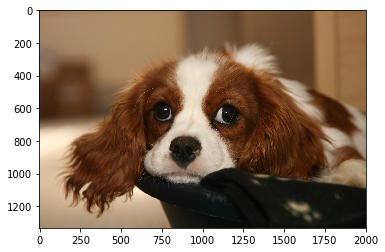

Dog Detected
Dog Breed: Bichon_frise


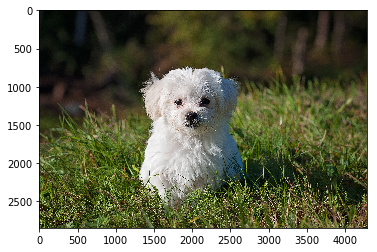

Dog Detected
Dog Breed: American_staffordshire_terrier


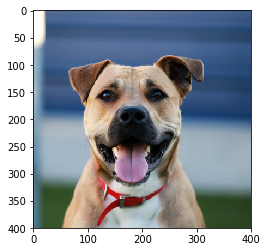

Hello, Human !
You look like a ...
Lowchen


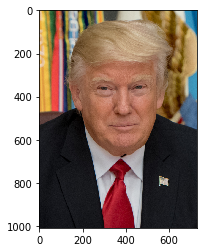

Hello, Human !
You look like a ...
Lowchen


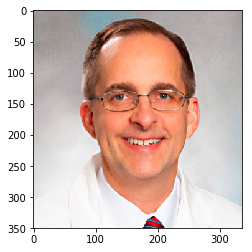

Hello, Human !
You look like a ...
Chinese_crested


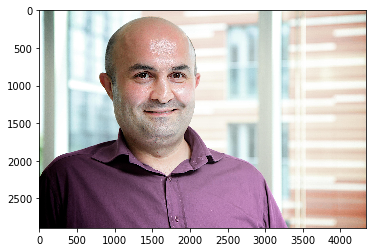

In [28]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
dog_recognition("dog1.jpg")
dog_recognition("dog2.jpg")
dog_recognition("dog3.jpg")
dog_recognition("human1.jpg")
dog_recognition("human2.jpg")
dog_recognition("human3.jpg")